In [ ]:
!pip install -q siuba plotnine

In [ ]:
#| echo: true
#| output: true

import numpy as np
import pandas as pd
#pd.set_option("display.max_rows", 10)
#from tabulate import tabulate
import siuba as si
import plotnine as p9
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plotnine theme
some_theme = p9.theme_dark() + p9.theme(
    text=p9.element_text(face="bold", size=20),
    plot_background=p9.element_rect(fill='gray', colour='black')
)

# read csv
#df = pd.read_csv("~/dev/ccg-web/csv/scom-gpols.csv", sep="\t", header=0)
#df = pd.read_csv("scom-gpols.csv", sep="\t", header=0)
df = pd.read_csv("https://raw.githubusercontent.com/nils-holmberg/ccg-web/main/csv/scom-gpols.csv", sep="\t", header=0)

#list(df.columns)
df.head()

,image,id,text
0,aline_lessner-higher_education-4185-7,4185,Several Swedish universities place high in Eur...
1,aline_lessner-students-4782-7,4782,Several Swedish universities place high in Eur...
2,aline_lessner-students-4783-7,4783,Several Swedish universities place high in Eur...
3,anna_sigge-fashion_from_forests-6404-7,6404,Knitted dress made of 100 per cent paper from ...
4,ann-sofi_rosenkvist-children_on_bikes-4910-7,4910,Learning to ride a bike is something you&#039;...


In [ ]:
import re
from pprint import pprint

In [ ]:
pprint(df['text'][0])

('Several Swedish universities place high in European rankings, and their '
 'research has contributed to the global success of Sweden’s many high-tech '
 'companies. Many Master&#039;s programmes are taught in English, and '
 'scholarships are available for international students. More than 20,000 '
 'foreign students are studying in Sweden, making for a vibrant, international '
 'study environment. A good part of their social life revolves around their '
 'student union. The union can often help you with finding accommodation and '
 'other practical matters. Relations between students and teachers are highly '
 'informal. Personal initiative and independent thinking are prized. Students '
 'are required to take an active role and contribute with opinions and ideas '
 'at lectures, seminars and in group discussions. Taking the initiative and '
 'questioning old presumptions is rewarding, especially in the long term. Many '
 'programmes also cooperate closely with industry.')


In [ ]:
# Run in python console
import nltk
nltk.download('stopwords')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# spacy for nlp analysis
import spacy
# Run in terminal or command prompt
!python3 -m spacy download en_core_web_sm
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm')#, disable=['parser', 'ner'])

2023-09-15 11:48:37.254450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


In [ ]:
!pip install --upgrade pandas
# topic modeling plotting tools
!pip install -q pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this


In [ ]:
df['text'] = df['text'].str.replace("&#039;", "'", regex=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# tokenization

In [ ]:
# Function to split the 'text' column into sentences and add a column for sentence number
def sentences_split(row):
    doc = nlp(str(row['text']))
    sentences = []
    for i, sent in enumerate(doc.sents):
        sentences.append({'id': row['id'], 'sentence': sent.text, 'sentence_number': i + 1})
    return sentences
# Apply the function to the 'df' DataFrame and create a new DataFrame 'sent_df'
sentences_list = df.apply(sentences_split, axis=1).explode().tolist()
df_sent = pd.DataFrame(sentences_list)
df_sent.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,id,sentence,sentence_number
0,4185,Several Swedish universities place high in Eur...,1
1,4185,Many Master's programmes are taught in English...,2
2,4185,"More than 20,000 foreign students are studying...",3
3,4185,A good part of their social life revolves arou...,4
4,4185,The union can often help you with finding acco...,5


# pos and ner analysis

In [ ]:
# Function to tokenize and analyze each sentence in 'df_sent' using spaCy
def tokens_split(row):
    doc = nlp(str(row['sentence']))
    tokens = []
    for i, token in enumerate(doc):
        entity = 'None' if token.ent_type_ == '' else token.ent_type_
        tokens.append({
            'id': row['id'],
            'sentence_number': row['sentence_number'],
            'token': token.text,
            'token_number': i + 1,
            'pos': token.pos_,
            'entity': entity,
            'lemma': token.lemma_
        })
    return tokens
# Apply the function to the 'sent_df' DataFrame and create a new DataFrame 'tokens_df'
tokens_list = df_sent.apply(tokens_split, axis=1).explode().tolist()
df_tokens = pd.DataFrame(tokens_list)
df_tokens.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,id,sentence_number,token,token_number,pos,entity,lemma
0,4185,1,Several,1,ADJ,None,several
1,4185,1,Swedish,2,ADJ,NORP,swedish
2,4185,1,universities,3,NOUN,None,university
3,4185,1,place,4,VERB,None,place
4,4185,1,high,5,ADJ,None,high


In [ ]:
# Filter the DataFrame where the 'token' column contains the case-insensitive substring 'swe'
df_tokens_filtered = df_tokens[df_tokens['token'].str.contains('swe', case=False)]
df_tokens_filtered.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(3300, 7)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


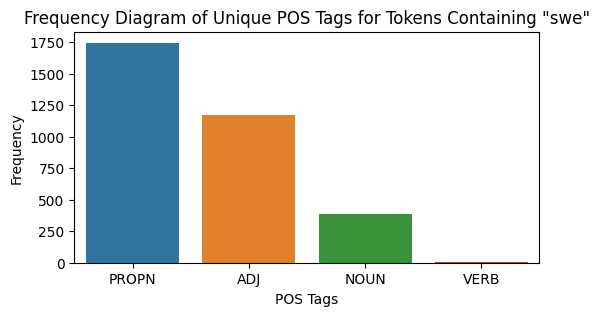

In [ ]:
# Plot the frequency diagram of unique POS tags in the 'pos_tag' column of the filtered DataFrame
plt.figure(figsize=(6, 3))
sns.countplot(data=df_tokens_filtered, x='pos', order=df_tokens_filtered['pos'].value_counts().index)
plt.title('Frequency Diagram of Unique POS Tags for Tokens Containing "swe"')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Write the 'tokens_df_sent' DataFrame to a TSV file called 'scom-gpols-tokens.tsv'
df_tokens.to_csv('scom-gpols-tokens.tsv', sep='\t', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


- link to dataset [scom-gpols-tokens.tsv](https://raw.githubusercontent.com/nils-holmberg/cca-nlp/main/csv/scom-gpols-tokens.tsv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


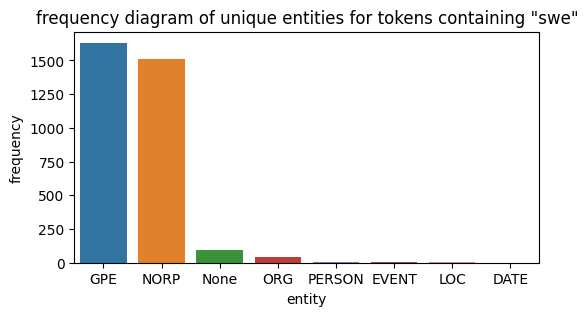

In [ ]:
# plot the frequency diagram of unique entities in the filtered DataFrame
plt.figure(figsize=(6, 3))
sns.countplot(data=df_tokens_filtered, x='entity', order=df_tokens_filtered['entity'].value_counts().index)
plt.title('frequency diagram of unique entities for tokens containing "swe"')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.show()

- CARDINAL - Numerals that do not fall under another type
- DATE - Absolute or relative dates or periods
- EVENT - Named hurricanes, battles, wars, sports events, etc.
- FAC - Buildings, airports, highways, bridges, etc.
- GPE - Countries, cities, states
- LANGUAGE - Any named language
- LAW - Named documents made into laws.
- LOC - Non-GPE locations, mountain ranges, bodies of water
- MONEY - Monetary values, including unit
- NORP - Nationalities or religious or political groups
- ORDINAL - "first", "second", etc.
- PERCENT - Percentage, including "%"
- PERSON - People, including fictional
- PRODUCT - Objects, vehicles, foods, etc. (not services)
- QUANTITY - Measurements, as of weight or distance
- TIME - Times smaller than a day
- WORK_OF_ART - Titles of books, songs, etc.

# topic modeling

In [ ]:
# Convert to list
data = df.text.values.tolist()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
pprint(data[:2])

['Several Swedish universities place high in European rankings, and their '
 'research has contributed to the global success of Sweden’s many high-tech '
 "companies. Many Master's programmes are taught in English, and scholarships "
 'are available for international students. More than 20,000 foreign students '
 'are studying in Sweden, making for a vibrant, international study '
 'environment. A good part of their social life revolves around their student '
 'union. The union can often help you with finding accommodation and other '
 'practical matters. Relations between students and teachers are highly '
 'informal. Personal initiative and independent thinking are prized. Students '
 'are required to take an active role and contribute with opinions and ideas '
 'at lectures, seminars and in group discussions. Taking the initiative and '
 'questioning old presumptions is rewarding, especially in the long term. Many '
 'programmes also cooperate closely with industry.',
 'Several Swed

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
# Remove Emails
data = [re.sub(r'\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub(r'\s+', ' ', str(sent)) for sent in data]

# Remove distracting single quotes
data = [re.sub(r"\'", "", str(sent)) for sent in data]

pprint(data[:2])

['Several Swedish universities place high in European rankings, and their '
 'research has contributed to the global success of Sweden’s many high-tech '
 'companies. Many Masters programmes are taught in English, and scholarships '
 'are available for international students. More than 20,000 foreign students '
 'are studying in Sweden, making for a vibrant, international study '
 'environment. A good part of their social life revolves around their student '
 'union. The union can often help you with finding accommodation and other '
 'practical matters. Relations between students and teachers are highly '
 'informal. Personal initiative and independent thinking are prized. Students '
 'are required to take an active role and contribute with opinions and ideas '
 'at lectures, seminars and in group discussions. Taking the initiative and '
 'questioning old presumptions is rewarding, especially in the long term. Many '
 'programmes also cooperate closely with industry.',
 'Several Swedi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


[['several', 'swedish', 'universities', 'place', 'high', 'in', 'european', 'rankings', 'and', 'their', 'research', 'has', 'contributed', 'to', 'the', 'global', 'success', 'of', 'sweden', 'many', 'high', 'tech', 'companies', 'many', 'masters', 'programmes', 'are', 'taught', 'in', 'english', 'and', 'scholarships', 'are', 'available', 'for', 'international', 'students', 'more', 'than', 'foreign', 'students', 'are', 'studying', 'in', 'sweden', 'making', 'for', 'vibrant', 'international', 'study', 'environment', 'good', 'part', 'of', 'their', 'social', 'life', 'revolves', 'around', 'their', 'student', 'union', 'the', 'union', 'can', 'often', 'help', 'you', 'with', 'finding', 'accommodation', 'and', 'other', 'practical', 'matters', 'relations', 'between', 'students', 'and', 'teachers', 'are', 'highly', 'informal', 'personal', 'initiative', 'and', 'independent', 'thinking', 'are', 'prized', 'students', 'are', 'required', 'to', 'take', 'an', 'active', 'role', 'and', 'contribute', 'with', 'opin

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


['several', 'swedish', 'universities', 'place', 'high', 'in_european_rankings', 'and', 'their', 'research', 'has', 'contributed', 'to', 'the', 'global_success', 'of', 'sweden', 'many', 'high', 'tech_companies', 'many', 'masters_programmes', 'are', 'taught', 'in', 'english', 'and', 'scholarships', 'are', 'available', 'for', 'international', 'students', 'more', 'than', 'foreign', 'students', 'are', 'studying', 'in', 'sweden', 'making', 'for', 'vibrant_international_study', 'environment', 'good', 'part', 'of', 'their', 'social', 'life_revolves', 'around', 'their', 'student', 'union', 'the', 'union', 'can', 'often_help', 'you', 'with', 'finding_accommodation', 'and', 'other', 'practical_matters', 'relations', 'between', 'students', 'and', 'teachers', 'are', 'highly_informal_personal', 'initiative', 'and_independent_thinking', 'are', 'prized', 'students', 'are', 'required', 'to', 'take', 'an_active_role', 'and', 'contribute', 'with', 'opinions', 'and', 'ideas', 'at', 'lectures_seminars_and'

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


[['several', 'swedish', 'university', 'place', 'high', 'european_ranking', 'research', 'contribute', 'global_success', 'sweden', 'many', 'high', 'tech_companie', 'many', 'masters_programme', 'teach', 'english', 'scholarship', 'available', 'international', 'student', 'foreign', 'student', 'study', 'sweden', 'make', 'vibrant_international', 'study', 'environment', 'good', 'part', 'social', 'life_revolve', 'student', 'union', 'union', 'often', 'help', 'finding_accommodation', 'practical_matter', 'relation', 'student', 'teacher', 'highly', 'informal_personal', 'initiative', 'independent_thinke', 'prize', 'student', 'require', 'take', 'contribute', 'opinion', 'idea', 'lectures_seminar', 'group', 'discussions_take', 'initiative', 'questioning_old', 'presumption', 'rewarding_especially', 'long', 'term', 'many', 'programme', 'also', 'cooperate_closely', 'industry']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
pprint(corpus[:1])

[[(0, 1),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 2),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 3),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 5),
  (45, 2),
  (46, 2),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 1)]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
id2word[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


'also'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


[[('also', 1),
  ('available', 1),
  ('contribute', 2),
  ('cooperate_closely', 1),
  ('discussions_take', 1),
  ('english', 1),
  ('environment', 1),
  ('european_ranking', 1),
  ('finding_accommodation', 1),
  ('foreign', 1),
  ('global_success', 1),
  ('good', 1),
  ('group', 1),
  ('help', 1),
  ('high', 2),
  ('highly', 1),
  ('idea', 1),
  ('independent_thinke', 1),
  ('industry', 1),
  ('informal_personal', 1),
  ('initiative', 2),
  ('international', 1),
  ('lectures_seminar', 1),
  ('life_revolve', 1),
  ('long', 1),
  ('make', 1),
  ('many', 3),
  ('masters_programme', 1),
  ('often', 1),
  ('opinion', 1),
  ('part', 1),
  ('place', 1),
  ('practical_matter', 1),
  ('presumption', 1),
  ('prize', 1),
  ('programme', 1),
  ('questioning_old', 1),
  ('relation', 1),
  ('require', 1),
  ('research', 1),
  ('rewarding_especially', 1),
  ('scholarship', 1),
  ('several', 1),
  ('social', 1),
  ('student', 5),
  ('study', 2),
  ('sweden', 2),
  ('swedish', 1),
  ('take', 1),
  ('te

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


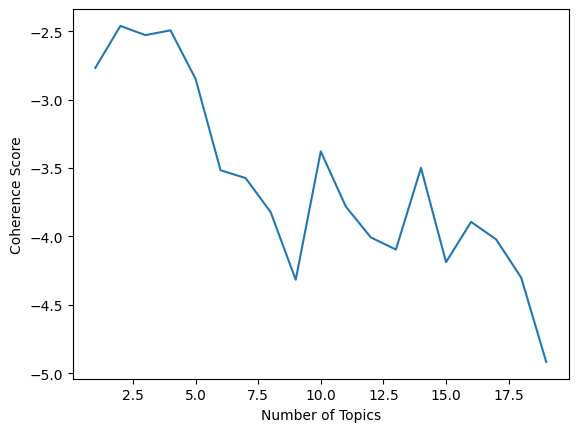

In [ ]:
topics = []
score = []

for i in range(1,20,1):
  #lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=i, iterations=10, passes=10, random_state=100)
  cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
  topics.append(i)
  score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


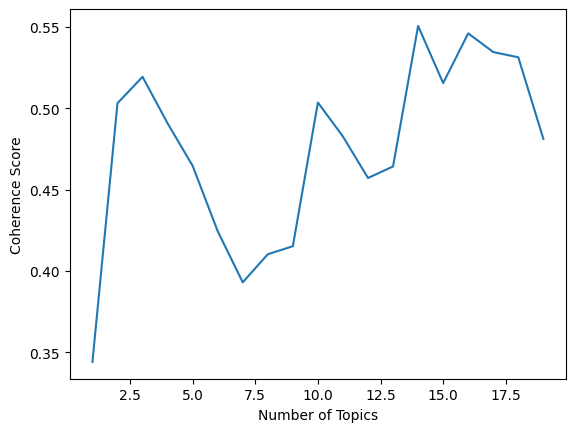

In [ ]:
topics = []
score = []

for i in range(1,20,1):
  #lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=i, iterations=10, passes=10, random_state=100)
  #cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
  cm = CoherenceModel(model=lda_model, texts=data_lemmatized, corpus=corpus, dictionary=id2word, coherence='c_v')
  topics.append(i)
  score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, iterations=10, passes=10, random_state=100)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
# Print topics
lda_model.print_topics(-1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


[(0,
  '0.031*"swedish" + 0.022*"sweden" + 0.011*"work" + 0.009*"people" + 0.008*"school" + 0.007*"many" + 0.007*"culture" + 0.007*"also" + 0.007*"country" + 0.007*"swede"'),
 (1,
  '0.054*"student" + 0.032*"sweden" + 0.022*"many" + 0.019*"study" + 0.015*"initiative" + 0.015*"high" + 0.014*"university" + 0.013*"work" + 0.013*"contribute" + 0.012*"education"'),
 (2,
  '0.025*"sweden" + 0.022*"swedish" + 0.014*"nature" + 0.013*"people" + 0.011*"swede" + 0.011*"time" + 0.009*"right" + 0.008*"also" + 0.007*"family" + 0.007*"take"'),
 (3,
  '0.028*"sweden" + 0.016*"day" + 0.015*"summer" + 0.013*"holiday" + 0.013*"child" + 0.012*"also" + 0.011*"family" + 0.011*"swedish" + 0.008*"many" + 0.008*"year"')]

In [ ]:
# Visualize the topics
#pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)
#vis


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
# Save the report
pyLDAvis.save_html(vis, 'scom-gpols-topics.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# some test

In [ ]:
from itertools import chain
# Create a new DataFrame to store the separated sentences and corresponding IDs
new_df = pd.DataFrame(columns=['id', 'sentence_number', 'sentence'])
# Iterate through each row in the original DataFrame
for index, row in df.iterrows():
    # Split the text into sentences
    sentences = str(row['text']).split('. ')
    # Create a list of sentence numbers
    sentence_numbers = list(range(1, len(sentences) + 1))
    # Create a list of IDs corresponding to each sentence
    ids = [row['id']] * len(sentences)
    # Create a temporary DataFrame
    temp_df = pd.DataFrame({'id': ids, 'sentence_number': sentence_numbers, 'sentence': sentences})
    # Append the temporary DataFrame to the new DataFrame
    new_df = pd.concat([new_df, temp_df], ignore_index=True)
# Display the new DataFrame
new_df.head()

,id,sentence_number,sentence
0,4185,1,Several Swedish universities place high in Eur...
1,4185,2,Many Master&#039;s programmes are taught in En...
2,4185,3,"More than 20,000 foreign students are studying..."
3,4185,4,A good part of their social life revolves arou...
4,4185,5,The union can often help you with finding acco...


In [ ]:
#| include: false
#| echo: true
#| output: true

if False:
    # Generate a frequency diagram of the variable 'Könstillhörighet'
    df_freq = si.count(df, si._.Könstillhörighet) >> si.arrange(-si._.n)

    # Plotting the frequency diagram using plotnine
    plot = (p9.ggplot(df_freq, p9.aes(x='Könstillhörighet', y='n')) +
            p9.geom_bar(stat='identity') +
            #p9.theme_minimal() +
            p9.ggtitle('Frequency Diagram of Könstillhörighet') +
            some_theme)
    #
    plot

In [ ]:
#| include: false
#| echo: true
#| output: true

if False:
    # Save the plotnine plot as a PNG image
    plot.save('../fig/genai-p9.png', width=10, height=8, dpi=300)

## matplotlib

In [ ]:
#| include: false
#| echo: true
#| output: true

if False:
    fig = plot.draw()
    #
    fig

In [ ]:
#| include: false
#| echo: true
#| output: true

if False:
    # Save the matplotlib figure as a PNG image
    fig.savefig('../fig/genai-plt.png', format='png', dpi=300)